<a href="https://colab.research.google.com/github/broom1001/kamedalab/blob/main/%E4%BA%80%E7%94%B0%E7%A0%94%EF%BC%BFAI_basketball_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git config --global user.email "ryusei.ouchi@gmail.com"
!git config --global user.name "broom1001"

# AI basketball analysis
<img class="emoji" alt="basketabll" height="300" width="700" src="https://raw.githubusercontent.com/hardik0/AI-basketball-analysis-on-google-colab/master/static/img/analysis.gif">

<img class="emoji" alt="basketabll" height="20" width="20" src="https://github.githubassets.com/images/icons/emoji/unicode/1f3c0.png"> **Analyze basketball shots and shooting pose with machine learning!**

This is an artificial intelligence application built on the concept of object detection. Analyze basketball shots by digging into the data collected from object detection. We can get the result by simply uploading files to the web App, or submitting a POST request to the API.

**Credits:**

Special thanks to:

**Tony Chou** for this amazing github repo **[AI-basketball-analysis](https://github.com/chonyy/AI-basketball-analysis)**

**CMU Perceptual Computing Lab** for **[OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose)**

In [ ]:
# First, change the runtime type to "GPU".  ユーザが主導でGPU利用へ切り替え
# Confirm runtime to GPU  以下でGPU利用になっているか確認
! nvcc --version
! nvidia-smi

In [ ]:
# Openpose version tag  Openposeのバージョン確認
#ver_openpose = "v1.6.0"  左の変数にバージョンを控える
# If CMake is old, Openpose build fails, so download the latest version
# CMakeが古いとOpenposeが作動しないためユーザが主導で新しいものをダウンロード、以下でバージョン確認
! cmake --version

In [ ]:
#Jun 18, 2020 - Rebuild the latest CMake at that time (about 15 minutes)
# CMakeをダウンロード
! wget -c "https://github.com/Kitware/CMake/releases/download/v3.17.3/cmake-3.17.3.tar.gz"
# ダウンロードしたアーカイブを展開
! tar xf cmake-3.17.3.tar.gz
# 展開したディレクトリに移動してCMakeをビルド
! cd cmake-3.17.3 && ./configure && make && sudo make install

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

## Install OpenPose


In [ ]:
# Install library

# Basic   基本的な開発ツール(コンパイラやビルドツール)
! sudo apt-get --assume-yes update
! sudo apt-get --assume-yes install build-essential
# OpenCV    OpenCVの開発用ヘッダーとライブラリ<-OpenposeにOpenCVが必要
! sudo apt-get --assume-yes install libopencv-dev
# General dependencies    機械学習やデータベース操作に必要なライブラリ(1行目Protocol Buffers、２行目Boost C＋＋の完全インストール)
! sudo apt-get --assume-yes install libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler
! sudo apt-get --assume-yes install --no-install-recommends libboost-all-dev
# Remaining dependencies, 14.04   Googleのログライブラリやフラグパーサー、LMDBなどをインストール
! sudo apt-get --assume-yes install libgflags-dev libgoogle-glog-dev liblmdb-dev
# Python3 libs    Python3のセットアップツールや開発ツールをインスト０ルし、必要なPythonライブラリ(numpy, protobuf, opencv-python)
! sudo apt-get --assume-yes install python3-setuptools python3-dev build-essential
! sudo apt-get --assume-yes install python3-pip
! sudo -H pip3 install --upgrade numpy protobuf opencv-python
# OpenCL Generic    OpenCLのヘッダーファイルや開発用ライブラリ、ViennaCLをインストール
! sudo apt-get --assume-yes install opencl-headers ocl-icd-opencl-dev
! sudo apt-get --assume-yes install libviennacl-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [872 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,395 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/

**Openposeをクローンする目的**


Openposeのソースコードをローカル環境に取得し、Openposeをビルドおよび実行するため

->必要に応じてコードをカスタマイズしたり、特定のバージョンをチェックアウトできるようになる＝特定の機能を追加したりバグを修正したりできる

In [ ]:
# Clone Openpose  OpenposeのGitをクローンしている
#! git clone  --depth 1 -b "$ver_openpose" https://github.com/CMU-Perceptual-Computing-Lab/openpose.git
! git clone https://github.com/CMU-Perceptual-Computing-Lab/openpose.git
! cd openpose && mkdir build && cd build

Cloning into 'openpose'...
remote: Enumerating objects: 16137, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 16137 (delta 20), reused 41 (delta 12), pack-reused 16084
Receiving objects: 100% (16137/16137), 84.47 MiB | 12.22 MiB/s, done.
Resolving deltas: 100% (11298/11298), done.


In [ ]:
#%rm -r openpose/build
#もしくはrm -r openpose/build

In [ ]:
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/installation.md#cmake-command-line-configuration-ubuntu-only
# Scenario 1 - Caffe not installed and OpenCV installed using apt-get
# Openposeのビルドを行う手順①Openposeのビルド設定：CMakeを実行してビルド設定
! cd openpose/build && cmake -DBUILD_PYTHON=ON ..

# If you want to download the COCO model as well, execute the following command. (Please change "# ! cd" part to "! cd".)
# COCOモデルをダウンロードする際は以下の通り
# ! cd openpose/build && cmake .. -D DOWNLOAD_BODY_COCO_MODEL=ON

# If you want to download the MPI model as well, execute the following command.
# MPIモデルのダウンロードする際は以下の通り
# ! cd openpose/build && cmake .. -D DOWNLOAD_BODY_MPI_MODEL=ON

CMake Warning (dev) at CMakeLists.txt:19 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMake Deprecation Warning at CMakeLists.txt:34 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or

In [ ]:
# Openpose Building   Openposeのビルドディレクトリに移動しmakeコマンドを実行しOpenposeのビルド
! cd openpose/build && make -j`nproc`

make: *** No targets specified and no makefile found.  Stop.


In [ ]:
# Openpose Installing   make installコマンドでインストール
! cd openpose/build && make install

make: *** No rule to make target 'install'.  Stop.


In [ ]:
# ! echo "include /usr/local/lib" >> /etc/ld.so.conf
    # /etc/ld.so.confファイルに新しいライブラリパスを追加
! grep -qxF "include /usr/local/lib" /etc/ld.so.conf || echo "include /usr/local/lib" | sudo tee -a /etc/ld.so.conf
#
! ldconfig    # ライブラリキャッシュを更新し、システムに新しいライブラリパスを認識させる

include /usr/local/lib
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link



In [ ]:
%ls /usr/local/python

ls: cannot access '/usr/local/python': No such file or directory


In [ ]:
# Run and check the sample
# The output analysis result is placed under "openpose/output" from the folder icon on the left menu of the Colab screen.
! cd openpose && mkdir output && ./build/examples/openpose/openpose.bin --video examples/media/video.avi --display 0  --write_video ./output/openpose.avi

/bin/bash: line 1: ./build/examples/openpose/openpose.bin: No such file or directory


## Detect poses on a test video

We are going to detect poses on the following youtube video:

In [ ]:
!pip install youtube-dl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00


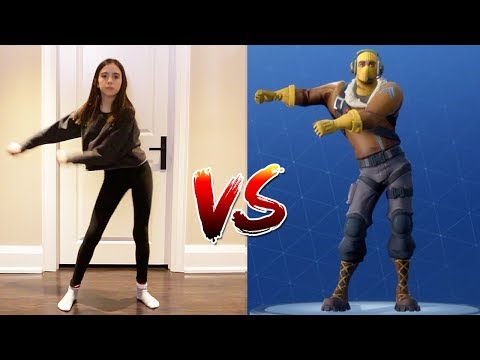

In [ ]:
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'RXABo9hm8B8'

YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

[youtube] RXABo9hm8B8: Downloading webpage
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libop

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

FileNotFoundError: [Errno 2] No such file or directory: 'output.mp4'

# <img class="emoji" alt="basketabll" height="20" width="20" src="https://github.githubassets.com/images/icons/emoji/unicode/1f3c0.png"> Analyze basketball shots and shooting pose with machine learning!

## Get a copy
Get a copy of this project by simply running the git clone command.

In [ ]:
# Original repository
#! git clone https://github.com/chonyy/AI-basketball-analysis.git

# Modified version
! git clone https://github.com/hardik0/AI-basketball-analysis-on-google-colab
%cd AI-basketball-analysis-on-google-colab

## Prerequisites
Before running the project, we have to install all the dependencies from requirements.txt

In [ ]:
! pip install -r colab_requirements.txt

You must restart the runtime

In [ ]:
%cd AI-basketball-analysis-on-google-colab

## Hosting

In [ ]:
# Download ngrok for tunneling.
!if [ ! -f ./ngrok ]; then \
 wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip; \
 unzip -o ngrok-stable-linux-amd64.zip; \
 fi

In [ ]:
# Then start a mini web server.
port = 5000
!pkill ngrok
!kill $(ps x | grep -v grep | grep http.server | awk '{print $1}') 2>/dev/null

get_ipython().system_raw(
    'python app.py && python3 -m http.server {} &'
    .format(port)
)

# And, forward the port using ngrok.
get_ipython().system_raw('./ngrok http {} &'.format(port))

**Port forwarding**

Via a `ngrok` tunnel from the local machine to the internet.

In [ ]:
# Get the public address from localhost:4040 (ngrok's web interface).
import time, urllib, json
time.sleep(1)  # Give ngrok time to startup.
ngrok_data = json.load(
    urllib.request.urlopen('http://localhost:4040/api/tunnels'))
ngrok_data['tunnels'][0]['public_url']

In [ ]:
# You can connect to this external address using your mobile phone!
!pip install -q qrcode
import qrcode
qrcode.make(ngrok_data['tunnels'][0]['public_url'])

Last, get the project hosted on google colab with a single command.

To restart Server/Flask you may click Menu: **Runtime->Restart runtime**

**Note:** After restart you can start with [here](#scrollTo=xz_TJD1MgEWR)

In [ ]:
# First run this cell then open above link
!python app.py

Or you can run below cell

In [ ]:
import os
import sys
import cv2

from flask import Flask, render_template, Response,  request, session, redirect, url_for, send_from_directory, flash, jsonify, abort
from werkzeug.utils import secure_filename
from PIL import Image


from src.config import shooting_result
from src.app_helper import getVideoStream, get_image, detectionAPI

app = Flask(__name__)

UPLOAD_FOLDER = './static/uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
#useless key, in order to use session
app.secret_key = "super secret key"

@app.route("/")
def index():
    return render_template("index.html")

@app.route('/detection_json', methods=['GET', 'POST'])
def detection_json():
    if request.method == 'POST':
        response = []
        f = request.files['image']
        # create a secure filename
        filename = secure_filename(f.filename)
        print("filename", filename)
        # save file to /static/uploads
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        print("filepath", filepath)
        f.save(filepath)
        detectionAPI(response, filepath)
        print(response)
        try:
            return jsonify(response), 200
        except FileNotFoundError:
            abort(404)


@app.route('/sample_detection', methods=['GET', 'POST'])
def upload_sample_image():
    if request.method == 'POST':
        response = []
        filename = "sample_image.jpg"
        print("filename", filename)
        filepath = "./static/uploads/sample_image.jpg"
        print("filepath", filepath)
        get_image(filepath, filename, response)
        return render_template("shot_detection.html", display_detection=filename, fname=filename, response=response)

@app.route('/basketball_detection', methods=['GET', 'POST'])
def upload_image():
    if request.method == 'POST':
        response = []
        f = request.files['image']
        # create a secure filename
        filename = secure_filename(f.filename)
        print("filename", filename)
        # save file to /static/uploads
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        print("filepath", filepath)
        f.save(filepath)
        get_image(filepath, filename, response)
        return render_template("shot_detection.html", display_detection=filename, fname=filename, response=response)

@app.route('/sample_analysis', methods=['GET', 'POST'])
def upload_video():
    global shooting_result
    shooting_result['attempts'] = 0
    shooting_result['made'] = 0
    shooting_result['miss'] = 0
    if (os.path.exists("./static/detections/trajectory_fitting.jpg")):
        os.remove("./static/detections/trajectory_fitting.jpg")
    if request.method == 'POST':
        filename = "sample_video.mp4"
        print("filename", filename)
        filepath = "./static/uploads/sample_video.mp4"
        print("filepath", filepath)
        session['video_path'] = filepath
        return render_template("shooting_analysis.html")

@app.route('/shooting_analysis', methods=['GET', 'POST'])
def upload_sample_video():
    global shooting_result
    shooting_result['attempts'] = 0
    shooting_result['made'] = 0
    shooting_result['miss'] = 0
    if (os.path.exists("./static/detections/trajectory_fitting.jpg")):
        os.remove("./static/detections/trajectory_fitting.jpg")
    if request.method == 'POST':
        f = request.files['video']
        # create a secure filename
        filename = secure_filename(f.filename)
        print("filename", filename)
        # save file to /static/uploads
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        print("filepath", filepath)
        f.save(filepath)
        session['video_path'] = filepath
        return render_template("shooting_analysis.html")

@app.route('/video_feed')
def video_feed():
    video_path = session.get('video_path', None)
    stream = getVideoStream(video_path)
    return Response(stream,
                    mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route("/result", methods=['GET', 'POST'])
def result():
    return render_template("result.html", shooting_result=shooting_result)

#disable caching
@app.after_request
def after_request(response):
    response.headers["Cache-Control"] = "no-cache, no-store, must-revalidate, public, max-age=0"
    response.headers["Expires"] = 0
    response.headers["Pragma"] = "no-cache"
    return response

if __name__ == '__main__':
    app.run(debug=True, use_reloader=True)